In [54]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View of all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# References to tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session
session = Session(engine)

## PRECIPITATION

In [8]:
one_year = []
precipitation = session.query(Measurement).filter(and_(func.date(Measurement.date) >= '2016-08-23'),func.date(Measurement.date) <= '2017-08-23')
for day in precipitation:
    one_year.append([day.date ,day.prcp])
    #print(f"{day.date} , {day.prcp}"
    
one_year_df = pd.DataFrame(one_year,columns = ["date", "precipitation"])    
    
sorted_one_year_df = one_year_df.sort_values(by=['date'], ascending=True).reset_index(drop = True)
#.set_index("date")
sorted_one_year_df.head()


#print(sorted_one_year_df["index"])


,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


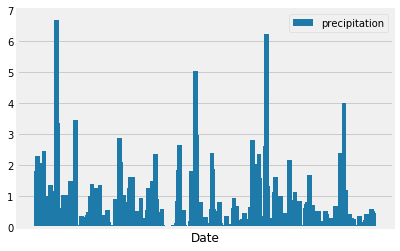

In [9]:
plt.bar(sorted_one_year_df["date"],sorted_one_year_df["precipitation"], label = "precipitation", width = 5, color = '#1E7AA8') 
plt.xlabel('Date')
plt.xticks([])
plt.legend()
plt.show()

In [10]:
#print(one_year)
sorted_one_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## STATIONS

In [11]:
stations_count = session.query(Station).count()
print(stations_count)

9


In [ ]:
#obs_count = session.query(Measurement).filter_by(station = "USC00519397").count()
#obs_count

In [12]:
active_stations = []
weather_stations = session.query(Station)
for station in weather_stations:
    station_id = station.station
    station_name = station.name
    obs_count = session.query(Measurement).filter_by(station = station_id).count()
    active_stations.append([station_name, station_id, obs_count])

active_stations_df = pd.DataFrame(active_stations,columns = ["station name","station id", "observation count"] )
sorted_active_stations_df = active_stations_df.sort_values(by=['observation count'], ascending=False).reset_index(drop=True)
sorted_active_stations_df

    

,station name,station id,observation count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [13]:
most_active_station = sorted_active_stations_df.iloc[0,0]
max_observation_count = sorted_active_stations_df.iloc[0,2]

print(f"The most active station is {most_active_station} with {max_observation_count} recorded entries.")



The most active station is WAIHEE 837.5, HI US with 2772 recorded entries.


In [14]:
most_active_station_id = sorted_active_stations_df.iloc[0,1]
most_active_station_id

'USC00519281'

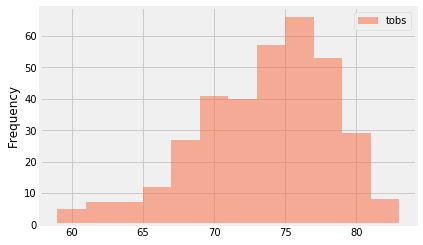

In [15]:
temp_list = []
temperatures = session.query(Measurement).filter_by(station=most_active_station_id ).filter(and_(func.date(Measurement.date) >= '2016-08-23'),func.date(Measurement.date) <= '2017-08-23')
for temp in temperatures:
    temp_list.append(temp.tobs)
temp_list
num_bins = 12
n, bins, patches = plt.hist(temp_list,num_bins,label = "tobs",alpha = 0.5,color = '#F96639' )
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Temperature Analysis II

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example


In [58]:
# trip dates

start = '2016-02-28'
end = '2016-03-05'


62.0 69.88636363636364 80.0


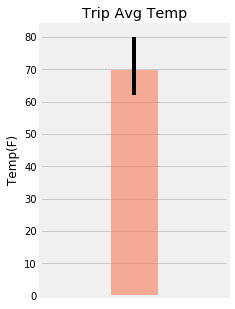

In [18]:
trip_temps = calc_temps(start, end)
TMIN = trip_temps[0][0]
TAVG = trip_temps[0][1]
TMAX = trip_temps[0][2]

print(TMIN,TAVG,TMAX)

plt.figure(figsize=(3,5))
plt.bar(1, TAVG, yerr = [[TAVG-TMIN],[TMAX-TAVG]], color = '#F96639', alpha = 0.5, width = 0.5)
plt.xticks([])
plt.xlim(0,2)
plt.ylabel('Temp(F)')
plt.title("Trip Avg Temp")
plt.show()


## Rainfall

In [39]:
rain_list = []
for station_id in sorted_active_stations_df["station id"]:
    results = session.query(func.sum(Measurement.prcp)).filter(Measurement.date >= start).filter(Measurement.date <= end).filter_by(station = station_id).all()
    rain_list.append([station_id,results[0][0]])
    
#print(rain_list)

rain_df = pd.DataFrame(rain_list,columns = ["station id", "total rain"]).sort_values(by=['total rain'], ascending=True).reset_index(drop=True)
rain_df

station_list = []
for id in rain_df["station id"]:
    results = session.query(Station).filter_by(station=id)
    for item in results:
        station_list.append((item.station, item.name, item.latitude, item.longitude, item.elevation))
    #station_list.append(results[0][0])
station_df = pd.DataFrame(station_list, columns = ["station id","station name", "latitude", "longitude", "elevation"])
station_df
station_and_rain_df = pd.merge(station_df,rain_df, how = "inner", on = "station id")
station_and_rain_df



,station id,station name,latitude,longitude,elevation,total rain
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.01
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.33
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN


## DAILY NORMALS

In [64]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [52]:
start

'2016-02-28'

In [82]:
sdate = dt.datetime.strptime(start,"%Y-%m-%d").date()   # start date
edate = dt.datetime.strptime(end,"%Y-%m-%d").date()   # end date
delta = edate - sdate       # as timedelta

normals_on_hol = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    short_day = f"{day.strftime('%m')}-{day.strftime('%d')}"
    tvals = daily_normals(short_day)
    tvals2 = [day, tvals[0][0], tvals[0][1], tvals[0][2]]
    normals_on_hol.append(tvals2)

normals_on_hol_df = pd.DataFrame(normals_on_hol,columns = ["date","tmin", "tavg","tmax"]).set_index('date')
normals_on_hol_df
    

,tmin,tavg,tmax
date,,,
2016-02-28,65.0,70.655172,80.0
2016-02-29,67.0,71.733333,79.0
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0


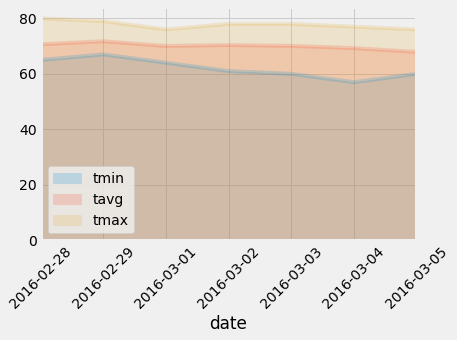

In [84]:
normals_on_hol_df.plot.area(stacked=False, alpha = 0.2, rot=45 )
